# Herb2021 

# Identifying Plant Species
---
This is a notebook for the [Herbarium 2021 - Half-Earth Challenge](https://www.kaggle.com/c/herbarium-2021-fgvc8/overview), to identify vascular plant specimens from around the world. There are more than 2.5M images representing nearly 65,000 species from the Americas and Oceania that have been aligned to a standardized plant list, which include lycophytes, ferns, gymnosperms, and flowering plants.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import os
import json
import collections

# Loading Data
---
(adapted from [YAROSLAV ISAIENKOV's notebook](https://www.kaggle.com/code/ihelon/herbarium-2021-exploratory-data-analysis))

Can't do a simple `pd.read_json()` because not all arrays of the same length.

In [2]:
PATH_BASE = "../input/herbarium-2021-fgvc8/"
PATH_TRAIN = os.path.join(PATH_BASE, "train/")
PATH_TRAIN_META = os.path.join(PATH_TRAIN, "metadata.json")
PATH_TRAIN_IMG = os.path.join(PATH_TRAIN, "images/")

with open(PATH_TRAIN_META) as train_md:
    metadata = json.load(train_md)

In [3]:
metadata.keys()

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses', 'institutions'])

In [4]:
len(metadata['annotations']), len(metadata['categories']), len(metadata['images'])

(2257759, 64500, 2257759)

print samples from the dict keys

In [5]:
print(metadata["annotations"][0])
print(metadata["images"][0])
print(metadata["categories"][0])
print(metadata["licenses"][0])
print(metadata["institutions"][0])

{'category_id': 60492, 'id': 1814367, 'image_id': 1814367, 'institution_id': 0}
{'file_name': 'images/604/92/1814367.jpg', 'height': 1000, 'id': 1814367, 'license': 0, 'width': 678}
{'family': 'Orchidaceae', 'order': 'Asparagales', 'name': 'Aa calceata (Rchb.f.) Schltr.', 'id': 0}
{'id': 0, 'name': 'Public Domain Dedication', 'url': 'http://creativecommons.org/publicdomain/zero/1.0/'}
{'id': 0, 'name': 'New York Botanical Garden'}


a few things pop out:
1. `category_id` needs to be inner joint with `categories` column
2. we are scored on macro f1 on the `id` and `category_id` columns
3. the columns we need are:
    - id
    - height
    - width
    - path
    - category_name
    - family_name
    - order_name
    - category_id

Join the columns with the same length first.

In [6]:
ids, categories, paths, heights, widths = [], [], [], [], []

for annotation, image in zip(metadata["annotations"], metadata["images"]):
    assert annotation["image_id"] == image["id"]
    ids.append(image["id"])
    paths.append(image["file_name"])
    heights.append(image['height'])
    widths.append(image['width'])
    categories.append(annotation["category_id"])
        
df_meta = pd.DataFrame({"id": ids, "height": heights, "width": widths, "path": paths, "category_id": categories})
df_meta.head()

,id,height,width,path,category_id
0,1814367,1000,678,images/604/92/1814367.jpg,60492
1,1308257,1000,666,images/108/24/1308257.jpg,10824
2,1270453,1000,739,images/330/76/1270453.jpg,33076
3,1123834,1000,672,images/247/99/1123834.jpg,24799
4,1042410,1000,675,images/170/18/1042410.jpg,17018


In [7]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2257759 entries, 0 to 2257758
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           int64 
 1   height       int64 
 2   width        int64 
 3   path         object
 4   category_id  int64 
dtypes: int64(4), object(1)
memory usage: 86.1+ MB


In [8]:
d_categories = {category["id"]: category["name"] for category in metadata["categories"]}
d_families = {category["id"]: category["family"] for category in metadata["categories"]}
d_orders = {category["id"]: category["order"] for category in metadata["categories"]}

df_meta["category_name"] = df_meta["category_id"].map(d_categories)
df_meta["family_name"] = df_meta["category_id"].map(d_families)
df_meta["order_name"] = df_meta["category_id"].map(d_orders)
df_meta = df_meta.reindex(columns = [col for col in df_meta.columns if col != 'category_id'] + ['category_id']) # move dependent variable to the end
df_meta.head()

,id,height,width,path,category_name,family_name,order_name,category_id
0,1814367,1000,678,images/604/92/1814367.jpg,Thysanocarpus curvipes Hook.,Brassicaceae,Brassicales,60492
1,1308257,1000,666,images/108/24/1308257.jpg,Cassia grandis L.f.,Fabaceae,Fabales,10824
2,1270453,1000,739,images/330/76/1270453.jpg,Leptospermum whitei Cheel,Myrtaceae,Myrtales,33076
3,1123834,1000,672,images/247/99/1123834.jpg,Fallopia scandens (L.) Holub,Polygonaceae,Caryophyllales,24799
4,1042410,1000,675,images/170/18/1042410.jpg,Cyperus dentatus Torr.,Cyperaceae,Poales,17018


check for any inconsistencies (duplicated, null etc)

In [9]:
print(df_meta.duplicated().sum())
print(df_meta.isnull().sum())

0
id               0
height           0
width            0
path             0
category_name    0
family_name      0
order_name       0
category_id      0
dtype: int64


now that the metadata is cleaned up, we can perform EDA.

# EDA
---
## Image EDA

In [10]:
def visualize_train_batch(paths, categories, families, orders):
    plt.figure(figsize=(16, 16))
    
    for idx, info in enumerate(zip(paths, categories, families, orders)):
        path, category, family, order = info
        
        plt.subplot(2, 3, idx + 1)
        
        image = cv2.imread(os.path.join(PATH_TRAIN, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        
        plt.title(
            f"FAMILY: {family} ORDER: {order}\n{category}", 
            fontsize=10,
        )
        plt.axis("off")
    
    plt.show()

In [11]:
def visualize(df, _id=None):
    """
    displays the pictures of the specimens if provided with the id,
    displays 6 random pictures if no id provided.
    """
    tmp = df.sample(6)
    if _id is not None:
        tmp = df[df["category_id"] == _id].sample(6)

    visualize_train_batch(
        tmp["path"].tolist(), 
        tmp["category_name"].tolist(),
        tmp["family_name"].tolist(),
        tmp["order_name"].tolist(),
    )

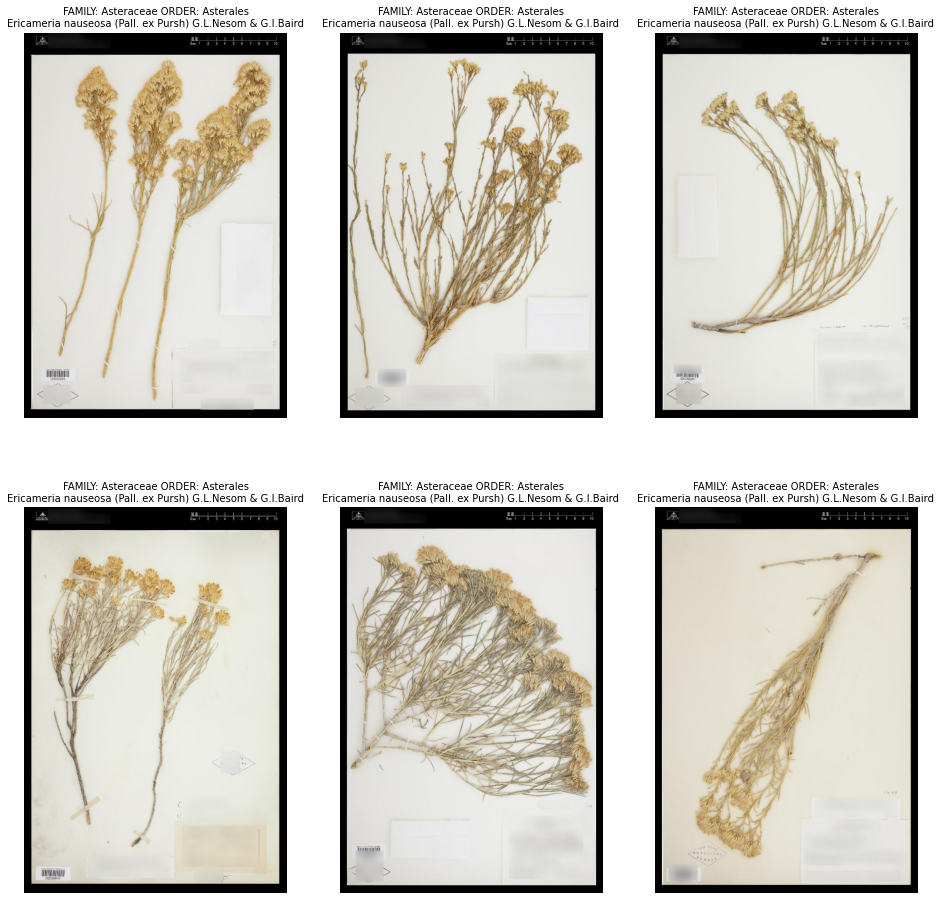

In [12]:
visualize(df_meta, 22344)

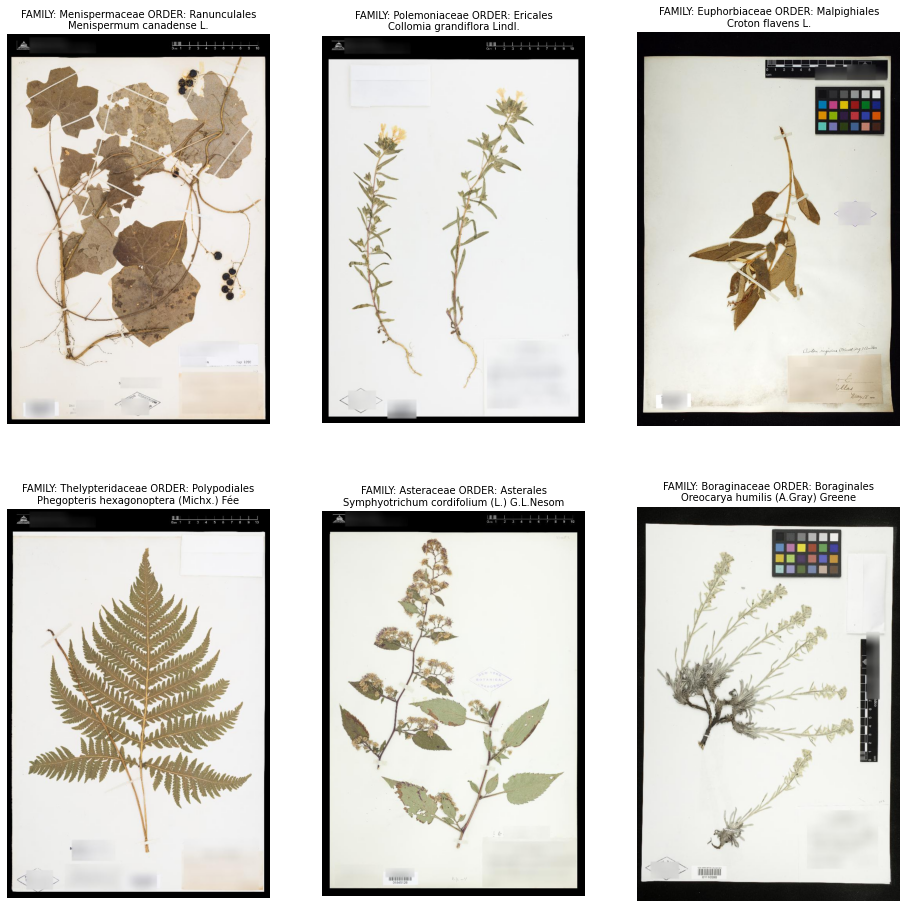

In [13]:
visualize(df_meta)

Of course, if we choose an id that has less than 6 pictures, we will get an error.

## Metadata EDA

Let's do an EDA for the metadata and check for discrepancies. We first check for the number of pictures in each category, and plot a frequency chart. There are 64500 categories, 

In [14]:
count = df_meta['category_id'].value_counts()
count

42811    3309
25229    2142
48372    2038
42843    1656
22344    1575
         ... 
47025       2
57300       2
6742        2
44413       2
37044       2
Name: category_id, Length: 64500, dtype: int64

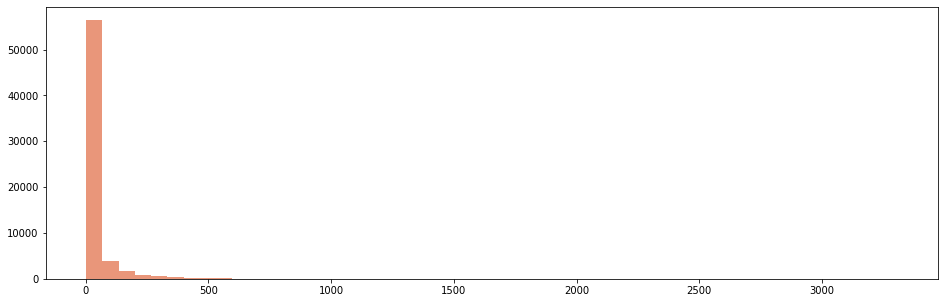

In [15]:
plt.figure(figsize=(16, 5))
plt.hist(df_meta['category_id'].value_counts(), bins=50, color='darksalmon');

As we can see, the distribution of the images has a long right-skew, i.e. the numbers of images per category are concentrated under roughly 200. We can also plot width and height to see the distribution of the image sizes.

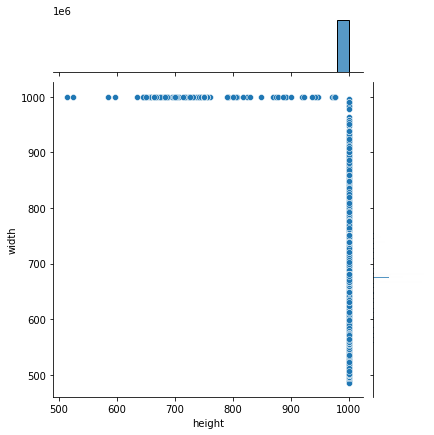

In [16]:
sns.jointplot(x=df_meta['height'], y=df_meta['width']);

Most of our images have height=1000, whereas the width is more evenly distributed between roughly 450 and 1000.

# Modeling

As this is an exploratory project, we will be using a couple of models to explore the efficiency vs accuracy between them.

In [17]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler, Adam
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models.vgg as VGG
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import StratifiedKFold

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
class Cfg:
    img_size = 224
    T_max = 5 # max no of epochs
    T_0 = 5 
    lr = 1e-4 # initial learning rate
    min_lr = 1e-6 #min learning rate
    weight_decay = 1e-6 # l2 penalty
    seed = 42
    num_classes = 64500
    num_epochs = 1
    n_fold = 5
    batch_size = 4

## Loading test dataset

In [20]:
PATH_TEST = os.path.join(PATH_BASE, "test/")
PATH_TEST_META = os.path.join(PATH_TEST, "metadata.json")

with open(PATH_TEST_META) as test_md:
    test_metadata = json.load(test_md)

# SQL style inner join
id2path = {
    img["id"]: img["file_name"] for img in test_metadata["images"]
}

In [21]:
df_submission = pd.read_csv(
    "../input/herbarium-2021-fgvc8/sample_submission.csv",
    index_col=0,
)

df_submission["path"] = df_submission.index.map(lambda x: id2path[x]) # join with id column then add a new path column
df_submission.head()

,Predicted,path
Id,,
0,0,images/000/0.jpg
1,0,images/000/1.jpg
2,0,images/000/2.jpg
3,0,images/000/3.jpg
4,0,images/000/4.jpg


## Data Preprocessing

perform stratified k fold. there's a way to perform it in a [lightning loop](https://github.com/PyTorchLightning/pytorch-lightning/blob/master/pl_examples/loop_examples/kfold.py)

In [22]:
skf = StratifiedKFold(n_splits=Cfg.n_fold, shuffle=True, random_state=Cfg.seed)

for fold, ( _, val_) in enumerate(skf.split(X=df_meta, y=df_meta.category_id)):
    df_meta.loc[val_ , "kfold"] = int(fold)
    
df_meta['kfold'] = df_meta['kfold'].astype(int)
train_df = df_meta[df_meta.kfold == fold]
val_df = df_meta[df_meta.kfold != fold]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


In [23]:
train_df.head()

,id,height,width,path,category_name,family_name,order_name,category_id,kfold
1,1308257,1000,666,images/108/24/1308257.jpg,Cassia grandis L.f.,Fabaceae,Fabales,10824,4
4,1042410,1000,675,images/170/18/1042410.jpg,Cyperus dentatus Torr.,Cyperaceae,Poales,17018,4
10,1676961,1000,671,images/455/24/1676961.jpg,Philodendron cordatum Kunth ex Schott,Araceae,Alismatales,45524,4
13,1458258,1000,683,images/465/14/1458258.jpg,Picrothamnus desertorum Nutt.,Asteraceae,Asterales,46514,4
15,2234628,1000,680,images/559/42/2234628.jpg,Simaba pohliana Boas,Simaroubaceae,Sapindales,55942,4


In [24]:
print(train_df.info())
print('='*40)
print(val_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451551 entries, 1 to 2257756
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             451551 non-null  int64 
 1   height         451551 non-null  int64 
 2   width          451551 non-null  int64 
 3   path           451551 non-null  object
 4   category_name  451551 non-null  object
 5   family_name    451551 non-null  object
 6   order_name     451551 non-null  object
 7   category_id    451551 non-null  int64 
 8   kfold          451551 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 34.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1806208 entries, 0 to 2257758
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   height         int64 
 2   width          int64 
 3   path           object
 4   category_name  object
 5   family_name    object
 6   order_name     o

In [25]:
class DataEncodings(Dataset):
    def __init__(
            self,
            paths, 
            categories=None,
            transforms=None,
            base_path=PATH_TRAIN):
        self.paths = df_meta.path
        self.categories = df_meta.category_id
        self.transforms = transforms
        self.base_path = base_path
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.base_path, self.paths[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
        if self.categories is None:
            return img
        
        label = self.categories[idx]
        return img, label

In [26]:
data_transforms = {
    "train": A.Compose([
        A.RandomResizedCrop(Cfg.img_size, Cfg.img_size),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "val": A.Compose([
        A.CenterCrop(Cfg.img_size, Cfg.img_size, p=1.),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [27]:
class DataModule(pl.LightningDataModule):

    def __init__(self):
        super().__init__()
#         self.train_transform = DataEncodings.train_transform
#         self.val_transform = DataEncodings.val_transform
        self.train = train_df
        self.val = val_df

    def setup(self):
        test_path = df_submission.path.tolist()
        self.train_data = DataEncodings(paths=self.train.path, categories=self.train.category_id, transforms=data_transforms['train'])
        self.val_data = DataEncodings(paths=self.val.path, categories=self.val.category_id, transforms=data_transforms['val'])
        self.test_data = DataEncodings(paths=test_path, base_path=PATH_TEST, transforms=data_transforms['val'])

    def train_dataloader(self):
        return DataLoader(dataset=self.train_data, batch_size=Cfg.batch_size, num_workers=4, 
                              pin_memory=True, shuffle=True, drop_last=True)

    def val_dataloader(self): 
        return DataLoader(dataset=self.val_data, batch_size=Cfg.batch_size, num_workers=4, 
                              pin_memory=True, shuffle=False, drop_last=False)
    
    def test_dataloader(self): 
        return DataLoader(dataset=self.test_data, batch_size=Cfg.batch_size, num_workers=4, 
                              pin_memory=True, shuffle=False, drop_last=False)

In [28]:
data_module = DataModule()
data_module.setup()

can tune hyperparams with [raytune](https://towardsdatascience.com/how-to-tune-pytorch-lightning-hyperparameters-80089a281646)

## model 1: vgg16

In [29]:
class VGG16(pl.LightningModule):
    """
    instantiates a VGG-16 model
    """
    def __init__(self):
        super().__init__()
        self.model = VGG.vgg16_bn(num_classes=Cfg.num_classes)
        self.criterion = CrossEntropyLoss()

    def forward(self, x):
        output = self.model(x)
        return output

    def configure_optimizers(self):
        optimizer = Adam(self.model.parameters(), lr=Cfg.lr, weight_decay=Cfg.weight_decay)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=Cfg.T_max, eta_min=Cfg.min_lr)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        data, target = batch
        loss = self.criterion(self.forward(data), target)
        self.log('train_loss', loss, prog_bar=True, logger=True, batch_size=Cfg.batch_size)
        return loss

    def validation_step(self, batch ,batch_idx):
        data, target = batch
        output = self.forward(data)
        loss = self.criterion(output, target)
        _, pred = torch.max(output, 1)
        correct = pred.eq(target.view_as(pred)).sum().item()
        self.log('val_loss', loss, prog_bar=True, logger=True, batch_size=Cfg.batch_size)
        return {'val loss': loss}

#     def validation_epoch_end(self, outputs):
#         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
#         sum_correct = sum([x['correct'] for x in outputs])
#         tensorboard_logs = {'val_loss':avg_loss}
#         print('Validation accuracy : ',sum_correct/10000,'\n\n') # self.arg.validation_size
#         return {'avg_val_loss':avg_loss, 'log':tensorboard_logs}    

    def test_step(self, batch, batch_idx):
        data, target = batch
        output = self.forward(data)
        pred = output.argmax(dim=1,keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        return {'test_loss':self.criterion(output,target), 'correct':correct}

#     def test_epoch_end(self, outputs):
#         avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
#         sum_correct = sum([x['correct'] for x in outputs])
#         tensorboard_logs = {'test_loss': avg_loss}
#         print('Test accuracy :',sum_correct/10000,'\n')
#         return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}

In [30]:
callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="vgg16-chkpt",
    save_top_k=-1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

trainer = Trainer(
    fast_dev_run=True,
    callbacks=[callback, EarlyStopping(monitor="val_loss")],
    max_epochs=Cfg.num_epochs,
    gpus=1,
    auto_lr_find=True,
#     deterministic=True,
    log_every_n_steps=5
)

In [31]:
vgg_model = VGG16()
# vgg_model.eval()

In [32]:
if __name__ == "__main__":
    trainer.fit(vgg_model, data_module)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]